# Text classification with Quanvolutional layer + Attention + HQLSTM

# Import libraries

Imports for computations

In [2]:
# !pip install custatevec_cu12
# !pip install pennylane pennylane-lightning
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from tqdm.notebook import tqdm

For plotting data

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.despine()
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

%matplotlib inline

<Figure size 640x480 with 0 Axes>

For data preprocessing and text cleaning

In [4]:
# !pip install langdetect
# !pip install contractions
# !pip install emoji==1.4.1
# !pip install nltk

import re
import string
import emoji
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize
from collections import Counter
from gensim.models import Word2Vec

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\den1s\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\den1s\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\den1s\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\den1s\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Set seed for reproductivity

In [5]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [6]:
num_qubits = 4
# device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
# dev = qml.device('qulacs.simulator', wires = range(num_qubits))
device = "cpu"
dev = qml.device("lightning.qubit", wires=range(num_qubits))
# dev = qml.device("default.tensor", method="tn", wires = range(num_qubits), **kwargs_tn)
dev

<lightning.qubit device (wires=4) at 0x274a3373590>

# Import data, data preprocessing and analysis

We use "Cyberbullying Classification" dataset from Kaggle. You can acquire more information about the data by the following link: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data

In [130]:
df = pd.read_csv('mental_health.csv')

In [131]:
df

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1
...,...,...
27972,posting everyday people stop caring religion ...,0
27973,okay definetly need hear guys opinion ive pret...,0
27974,cant get dog think ill kill myselfthe last thi...,1
27975,whats point princess bridei really think like ...,1


In [132]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [133]:
df.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


Define cleaning functions. Source: https://www.kaggle.com/code/ludovicocuoghi/detecting-bullying-tweets-pytorch-lstm-bert

In [134]:
df.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [135]:
print(f'There are around {int(df["text"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 5 duplicated tweets, we will remove them.


In [136]:
df.drop_duplicates("text", inplace=True)

In [137]:
df.label.value_counts()

label
0    14134
1    13838
Name: count, dtype: int64

As we can see, after cleaning classes are unbalanced so we will drop "other_cyberbullying" class as there is not enough data. Later we will oversample "not_cyberbullying" class.

In [138]:
df['text_len'] = [len(text.split()) for text in df.text]

In [139]:
df[df["label"] == 1]['text_len'].mean()

96.66136724960255

In [140]:
df[df["label"] == 0]['text_len'].mean()

47.40045280882977

In [141]:
df_label_0 = df[df['label'] == 0].sort_values(by='text_len', ascending=False)
df_label_1 = df[df['label'] == 1].sort_values(by='text_len', ascending=False)

# Determine how many rows to drop from each (half)
n_to_drop_0 = 3*len(df_label_0) // 4
n_to_drop_1 = 3*len(df_label_1) // 4

# Drop rows from class 0
df_label_0_dropped = df_label_0.iloc[n_to_drop_0:].drop(columns=['text_len'])

# Drop rows from class 1
df_label_1_dropped = df_label_1.iloc[n_to_drop_1:].drop(columns=['text_len'])

# Concatenate the two DataFrames back into a single DataFrame
df = pd.concat([df_label_0_dropped, df_label_1_dropped]).reset_index(drop=True)

In [142]:
df

,text,label
0,gathering bunch fat people zombie apocalypse c...,0
1,flair change time boys youngest sub anymore im...,0
2,see year bitches fill next year im going leave...,0
3,last post wanted see reaction posted random di...,0
4,got called broski girl im talking fuck got gia...,0
...,...,...
6989,lifel,1
6990,name,1
6991,sorry,1
6992,medicationmarijuana,1


In [143]:
df['text_len'] = [len(text.split()) for text in df.text]

In [144]:
# # Set target count
# target_count = 4901

# # Dropping random items to equalize the counts
# for column in df.columns:
#     current_count = df[column].value_counts().iloc[0]  # Get current count of the first category
#     if current_count > target_count:
#         # Calculate the number of items to drop
#         n_to_drop = current_count - target_count
        
#         # Select random indices to drop
#         indices_to_drop = df[df[column] == df[column].value_counts().index[0]].sample(n=n_to_drop, random_state=1).index

#         # Drop the selected rows
#         df = df.drop(indices_to_drop)

# # Resulting DataFrame value counts
# print("Value Counts after Dropping Random Items:")
# print(df.sentiment.value_counts())

C:\Users\den1s\AppData\Local\Temp\ipykernel_17288\631618343.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')


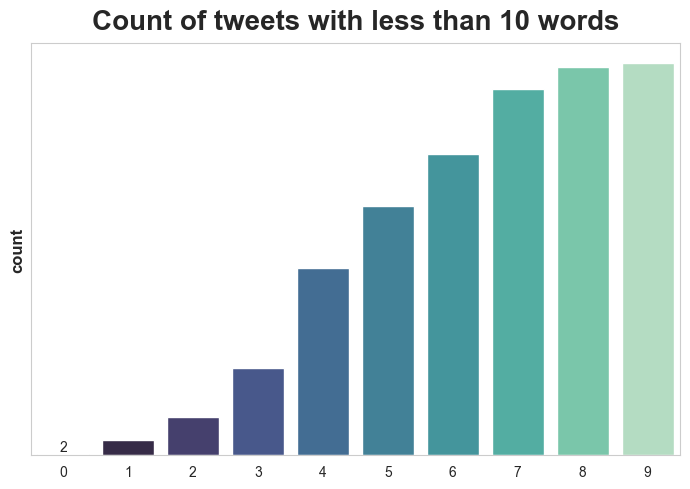

In [145]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

C:\Users\den1s\AppData\Local\Temp\ipykernel_17288\2060477503.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')


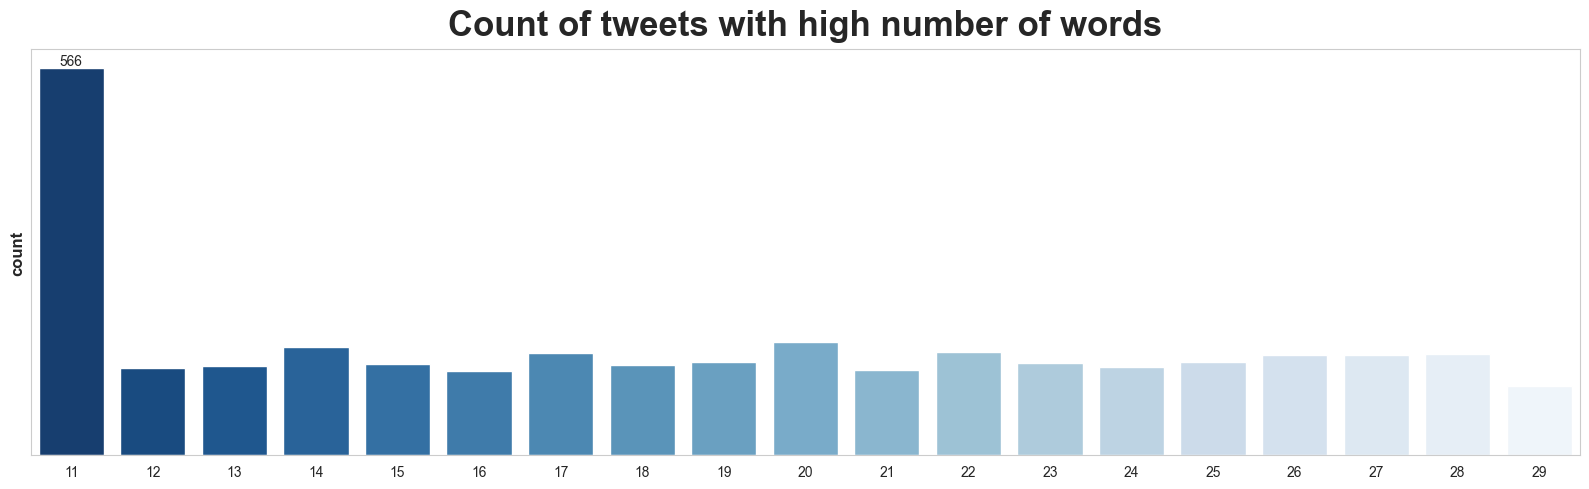

In [146]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
# df = df[df['text_len'] < df['text_len'].quantile(0.995)]

In [147]:
max_len = np.max(df['text_len'])
max_len

29

In [148]:
df.label.value_counts()

label
0    3534
1    3460
Name: count, dtype: int64

In [ ]:
# df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

C:\Users\den1s\AppData\Local\Temp\ipykernel_12612\4141559953.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})


Text tokenization

In [149]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [150]:
vocabulary, tokenized_column = Tokenize(df["text"], max_len)

In [151]:
X = df['text']
y = df['label']

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Text embedding with pre-trained Word2vec model

In [153]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [154]:
EMBEDDING_DIM = 200

In [155]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [156]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

In [157]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (12023, 200)


In [158]:
X = tokenized_column
y = df['label'].values

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Oversampling

In [160]:
# ros = RandomOverSampler()
# X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train))

In [161]:
X_train.shape

(5595, 29)

Finally, we define our preprocessed dataset and loaders

In [162]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [163]:
BATCH_SIZE = 32

In [164]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

# Implementation of the classical model

In this paragraph we will implement model with classical convolution and LSTM in order to compare it with its hybrid-quantum analogue

In [165]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim )
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)

In [166]:
class ClassicalModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, in_channels, out_channels, kernel_size, stride, padding, hidden_dim, num_classes, lstm_layers):
        super(ClassicalModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # embedded = self.conv(embedded.unsqueeze(1))
        # # Pass embeddings to LSTM
        # out, hidden = self.lstm(embedded.reshape(-1, embedded.size(1)*embedded.size(2), embedded.size(-1)), hidden)
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        return h0, c0

# Implementation of the hybrid-quantum model

In [167]:
@qml.qnode(dev, interface='torch')
def quanvcirc(patch, weights, wires=range(num_qubits)):
    # Angle embedding of the patch (reshape to match expected size)
    qml.AngleEmbedding(patch, wires=wires, rotation='Y')

    # Apply RX rotations based on the weights
    qml.RX(weights[0][0], wires=0)
    qml.RX(weights[0][1], wires=1)
    qml.RY(weights[1][0], wires=2)
    qml.RY(weights[1][1], wires=3)

    # Apply CNOT gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])
    # Apply RY rotations based on the weights


    # Return the expectation values of Pauli-Z measurements on all qubits
    return qml.expval(qml.PauliZ(0))

In [168]:
print(qml.draw(quanvcirc)(np.ones((1, 4)), np.ones((2, 2))))

0: ─╭AngleEmbedding(M0)──RX(1.00)─╭●───────╭X─┤  <Z>
1: ─├AngleEmbedding(M0)──RX(1.00)─╰X─╭●────│──┤     
2: ─├AngleEmbedding(M0)──RY(1.00)────╰X─╭●─│──┤     
3: ─╰AngleEmbedding(M0)──RY(1.00)───────╰X─╰●─┤     

M0 = 
[[1. 1. 1. 1.]]


In [169]:
class QuanConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(QuanConv2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Define weights and biases as trainable parameters
        self.weights = nn.Parameter(
            torch.randn(out_channels, in_channels, kernel_size, kernel_size), requires_grad = True
        )

    def forward(self, input):
        # Extract dimensions
        batch_size, in_channels, input_height, input_width = input.shape

        # Calculate output dimensions
        output_height = (input_height - self.kernel_size + 2 * self.padding) // self.stride + 1
        output_width = (input_width - self.kernel_size + 2 * self.padding) // self.stride + 1

        # Initialize output tensor
        output = torch.zeros(batch_size, self.out_channels, output_height, output_width)

        # If padding is required, add it to the input
        if self.padding > 0:
            input = F.pad(input, (self.padding, self.padding, self.padding, self.padding))

        # Perform convolution
        for b in range(batch_size):
            for c_out in range(self.out_channels):
                for h in range(output_height):
                    for w in range(output_width):
                        h_start = h * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = w * self.stride
                        w_end = w_start + self.kernel_size

                        # Slice the input for the current window
                        input_slice = input[b, :, h_start:h_end, w_start:w_end]

                        # Perform element-wise multiplication and sum with bias
                        output[b, c_out, h, w] = quanvcirc(input_slice.reshape(1, self.kernel_size * self.kernel_size), self.weights[c_out].squeeze(0))
        return output

In [170]:
qdi_reps1 = 2
qdi_reps2 = 2
qdi_depth = 1

In [171]:
@qml.qnode(dev, interface='torch', diff_method="adjoint")
def qdi_circuit(weights, input_array, wires=range(num_qubits)):
    for r in range(qdi_reps1):
        for i in range(len(wires)):
            qml.RX(weights[r][i], wires=wires[i])
        for j in range(len(wires)-1):
            qml.CNOT(wires=[wires[j], wires[j+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
        # qml.Barrier()
    for d in range(qdi_depth):
        qml.AngleEmbedding(input_array, wires=range(num_qubits), rotation='Z')
        for r in range(qdi_reps2):
            for i in range(len(wires)):
                qml.RX(weights[qdi_reps1+d*r][i], wires=wires[i])
            for j in range(len(wires)-1):
                qml.CNOT(wires=[wires[j], wires[j+1]])
            qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
            # qml.Barrier()
        # qml.Barrier()
    return [qml.expval(qml.PauliY(w)) for w in wires]

In [172]:
print(qml.draw(qdi_circuit)(np.ones((qdi_reps1 + qdi_reps2, num_qubits)), np.ones((4, 4))))

0: ──RX(1.00)─╭●───────╭X──RX(1.00)─╭●───────╭X─╭AngleEmbedding(M0)──RX(1.00)─╭●───────╭X──RX(1.00)
1: ──RX(1.00)─╰X─╭●────│───RX(1.00)─╰X─╭●────│──├AngleEmbedding(M0)──RX(1.00)─╰X─╭●────│───RX(1.00)
2: ──RX(1.00)────╰X─╭●─│───RX(1.00)────╰X─╭●─│──├AngleEmbedding(M0)──RX(1.00)────╰X─╭●─│───RX(1.00)
3: ──RX(1.00)───────╰X─╰●──RX(1.00)───────╰X─╰●─╰AngleEmbedding(M0)──RX(1.00)───────╰X─╰●──RX(1.00)

──╭●───────╭X─┤  <Y>
──╰X─╭●────│──┤  <Y>
─────╰X─╭●─│──┤  <Y>
────────╰X─╰●─┤  <Y>

M0 = 
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [173]:
class HQLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, num_qubits):
        super(HQLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Combined weights for efficiency
        self.W_input = nn.Parameter(torch.rand(4 * num_qubits, input_size), requires_grad = True).float()
        self.W_hid = nn.Parameter(torch.rand(4 * num_qubits, hidden_size), requires_grad = True).float()
        self.W_quan = nn.Parameter(torch.zeros(4, qdi_reps1 + qdi_reps2, num_qubits), requires_grad = True).float()
        self.W = nn.Parameter(torch.rand(4, hidden_size, num_qubits), requires_grad = True).float()

    def forward(self, x, hidden):
        h_prev, c_prev = hidden

        yield_input = F.linear(x, self.W_input)
        yield_hidden = F.linear(h_prev, self.W_hid)
        # Concatenate input and previous hidden state
        combined = yield_input + yield_hidden
        # combined = torch.cat((yield_input, yield_hidden), dim=1)

        # Apply linear transformation

        # Split into gates
        # combined = torch.cat([torch.stack(qdi_circuit(self.W_quan[i], combined[:, i:i*num_qubits].reshape(-1, num_qubits))) for i in range(num_qubits)], dim = 0)
        i_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[0], combined[:, :num_qubits].reshape(-1, num_qubits))).T.float(), self.W[0])
        f_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[1], combined[:, num_qubits:2*num_qubits].reshape(-1, num_qubits))).T.float(), self.W[1])
        g_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[2], combined[:, 2*num_qubits:3*num_qubits].reshape(-1, num_qubits))).T.float(), self.W[2])
        o_gate = F.linear(torch.stack(qdi_circuit(self.W_quan[3], combined[:, 3*num_qubits:4*num_qubits].reshape(-1, num_qubits))).T.float(), self.W[3])



        # combined = torch.cat((i_gate, f_gate, g_gate, o_gate), dim=0).float()
        # gates = F.linear(combined, self.W)

        # # Split into gates
        # i_gate, f_gate, g_gate, o_gate = gates.chunk(4, 0)

        # Apply non-linearities
        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate)
        g_gate = torch.tanh(g_gate)
        o_gate = torch.sigmoid(o_gate)

        # Update cell state
        c_next = (f_gate * c_prev) + (i_gate * g_gate)

        # Update hidden state
        h_next = o_gate * torch.tanh(c_next)

        return h_next, c_next


class HQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_qubits, num_layers=1):
        super(HQLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm_cells = nn.ModuleList([HQLSTMCell(input_size if l==0 else hidden_size, hidden_size, num_qubits) for l in range(num_layers)])


    def forward(self, x, hidden=None):
        batch_size, seq_len, _ = x.size()

        if hidden is None:
             h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
             c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        else:
            h0, c0 = hidden

        output_seq = []

        for t in range(seq_len):
            input_t = x[:, t, :] # input at current timestep
            # print(f'step:{t}/{seq_len}, hidden:')

            new_h = []
            new_c = []

            for layer in range(self.num_layers):

                # Get hidden state for current layer
                h_t, c_t = self.lstm_cells[layer](input_t, (h0[layer], c0[layer]))

                # Update hidden states for next timestep, for current layer
                new_h.append(h_t)
                new_c.append(c_t)
                input_t = h_t # The output of current layer is input for the next

            h0 = torch.stack(new_h)
            c0 = torch.stack(new_c)
            # Append hidden state at the topmost layer
            output_seq.append(h_t.unsqueeze(1))

        # Concatenate the outputs over the sequence length
        output_seq = torch.cat(output_seq, dim=1) # output_seq is of shape (batch_size, seq_len, hidden_size)

        return output_seq, (h0, c0)


Toy hybrid-quantum model for benchmarking

In [174]:
class ToyHQModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, in_channels, out_channels, kernel_size, stride, padding, hidden_dim, num_qubits, num_classes, lstm_layers):
        super(ToyHQModel, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.num_layers = lstm_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.attention = Attention(hidden_dim)
        # self.conv = QuanConv2D(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)
        self.lstm = HQLSTM(embedding_dim, hidden_dim, num_qubits, lstm_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # x = self.conv(x.unsqueeze(1))
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        return h0, c0

In [175]:
class HybridQuantumModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, in_channels, out_channels, kernel_size, stride, padding, hidden_dim, num_qubits, num_classes, lstm_layers):
        super(HybridQuantumModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = HQLSTM(embedding_dim, hidden_dim, num_qubits, lstm_layers)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # embedded = self.conv(embedded.unsqueeze(1)).to(device)
        # Pass embeddings to LSTM
        # out, hidden = self.lstm(embedded.reshape(-1, embedded.size(1)*embedded.size(2), embedded.size(-1)))
        out, hidden = self.lstm(embedded)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out

# Training the models

In [176]:
NUM_CLASSES = 2 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 16 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers
IN_CHANNELS = 1
OUT_CHANNELS = 5
KERNEL_SIZE = 2
STRIDE = 1
PADDING = 1


LR = 0.001 #Learning rate
EPOCHS = 10 #Number of training epoch

criterion = nn.NLLLoss()

In [177]:
classical_model = ClassicalModel(VOCAB_SIZE, EMBEDDING_DIM, IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, STRIDE, PADDING, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS)
classical_model = classical_model
# classical_model = torch.compile(classical_model)

cl_optimizer = torch.optim.AdamW(classical_model.parameters(), lr=LR, weight_decay = 5e-6)

print(classical_model)

ClassicalModel(
  (embedding): Embedding(12023, 200)
  (conv): Conv2d(1, 5, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (lstm): LSTM(200, 16, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=32, out_features=16, bias=True)
    (v): Linear(in_features=16, out_features=1, bias=False)
  )
  (fc): Linear(in_features=16, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [178]:
def initialize_weights(model):
    for name, param in model.named_parameters():
        if 'embedding' in name:
            nn.init.uniform_(param, -0.1, 0.1)
        elif 'lstm' in name:
            if 'weight' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        elif 'fc' in name:
            nn.init.xavier_uniform_(param)

In [179]:
hybrid_quantum_model = HybridQuantumModel(VOCAB_SIZE, EMBEDDING_DIM, IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, STRIDE, PADDING, HIDDEN_DIM, num_qubits, NUM_CLASSES, LSTM_LAYERS)
# initialize_weights(hybrid_quantum_model)


# hybrid_quantum_model = torch.compile(hybrid_quantum_model)

hq_optimizer = torch.optim.AdamW(hybrid_quantum_model.parameters(), lr=LR, weight_decay = 5e-6)

print(hybrid_quantum_model)

HybridQuantumModel(
  (embedding): Embedding(12023, 200)
  (lstm): HQLSTM(
    (lstm_cells): ModuleList(
      (0): HQLSTMCell()
    )
  )
  (attention): Attention(
    (attn): Linear(in_features=32, out_features=16, bias=True)
    (v): Linear(in_features=16, out_features=1, bias=False)
  )
  (fc): Linear(in_features=16, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [180]:
import time

def train(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)
    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        it = 0
        train_loss = 0
        test_loss = 0

        train_accuracy = 0
        test_accuracy = 0

        # train step
        model.train()
        for batch in train_dataloader:
            start_time = time.time()
            X = batch[0]
            y = batch[1]

            h = model.init_hidden(y.size(0))
            # model forward-pass
            preds, h = model(X, h)

            # model backward-pass
            optimizer.zero_grad() # t.grad = torch.tensor([0., 0., 0.])
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step() # t = t - lr * t.grad
            end_time = time.time()
            execution_time = end_time - start_time

            # save loss and accuracy
            train_loss += loss.detach().cpu().numpy()
            # print(f'batch: {it+1}/{len(train_dataloader)}, loss: {train_loss/(it+1):.4f}, time: {execution_time:.4f}')
            it += 1
            train_accuracy += (preds.argmax(-1).detach() == y).cpu().numpy().mean()


        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_losses[i_epoch] = train_loss
        train_accuracy_arr[i_epoch] = train_accuracy

        # test step
        model.eval()
        for batch in test_dataloader:
            X = batch[0]
            y = batch[1]

            h = model.init_hidden(y.size(0))

            with torch.no_grad():
                # model forward-pass
                preds, h = model(X, h)
                loss = criterion(preds, y)

                # save loss and accuracy
                test_loss += loss.detach().cpu().numpy()
                test_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()


        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)

        test_losses[i_epoch] = test_loss
        test_accuracy_arr[i_epoch] = test_accuracy

    return train_losses, test_losses, train_accuracy_arr, test_accuracy_arr

def train_for_hqnn(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)
    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        it = 0

        train_loss = 0
        test_loss = 0

        train_accuracy = 0
        test_accuracy = 0

        # train step
        model.train()
        for batch in train_dataloader:
            start_time = time.time()
            X = batch[0]
            y = batch[1]

            # model forward-pass
            preds = model(X)

            # model backward-pass
            optimizer.zero_grad() # t.grad = torch.tensor([0., 0., 0.])
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step() # t = t - lr * t.grad
            end_time = time.time()
            execution_time = end_time - start_time

            # save loss and accuracy
            train_loss += loss.detach().cpu().numpy()
            print(f'it: {it+1}/{len(train_dataloader)}, loss: {train_loss/(it+1):.4f}, time: {execution_time:.4f}')
            it += 1
            train_accuracy += (preds.argmax(-1).detach() == y).cpu().numpy().mean()


        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_losses[i_epoch] = train_loss

        train_accuracy_arr[i_epoch] = train_accuracy

        # test step
        model.eval()
        for batch in test_dataloader:
            X = batch[0]
            y = batch[1]


            with torch.no_grad():
                # model forward-pass
                preds = model(X)
                loss = criterion(preds, y)

                # save loss and accuracy
                test_loss += loss.detach().cpu().numpy()
                test_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()


        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)

        test_losses[i_epoch] = test_loss
        test_accuracy_arr[i_epoch] = test_accuracy

    return train_losses, test_losses, train_accuracy_arr, test_accuracy_arr

In [181]:
cl_train_losses, \
    cl_test_losses, \
    cl_train_accuracy_arr, \
    cl_test_accuracy_arr = train(classical_model, criterion=criterion,
                              optimizer=cl_optimizer,
                              train_dataloader=train_loader,
                              test_dataloader=test_loader,
                              num_epochs=EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

In [183]:
cl_test_accuracy_arr

tensor([0.86555233, 0.87936047, 0.88081395, 0.88008721, 0.8684593 ,
        0.87063953, 0.87718023, 0.87645349, 0.87936047, 0.87863372], requires_grad=True)

In [189]:
cl_train_accuracy_arr

tensor([0.77765805, 0.8908046 , 0.93372845, 0.96138649, 0.97755029,
        0.99030172, 0.99425287, 0.99748563, 0.99874282, 0.99928161], requires_grad=True)

In [185]:
hq_train_losses, \
    hq_test_losses, \
    hq_train_accuracy_arr, \
    hq_test_accuracy_arr = train_for_hqnn(hybrid_quantum_model, criterion=criterion,
                              optimizer=hq_optimizer,
                              train_dataloader=train_loader,
                              test_dataloader=test_loader,
                              num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function ZipFile.__del__ at 0x00000274F190AF20>
Traceback (most recent call last):
  File "c:\Users\den1s\AppData\Local\Programs\Python\Python311\Lib\zipfile.py", line 1870, in __del__
    self.close()
  File "c:\Users\den1s\AppData\Local\Programs\Python\Python311\Lib\zipfile.py", line 1892, in close
    self._fpclose(fp)
  File "c:\Users\den1s\AppData\Local\Programs\Python\Python311\Lib\zipfile.py", line 1989, in _fpclose
    assert self._fileRefCnt > 0
AssertionError: 


it: 1/174, loss: 0.7030, time: 21.4352
it: 2/174, loss: 0.6941, time: 29.9690
it: 3/174, loss: 0.7117, time: 36.0505
it: 4/174, loss: 0.7072, time: 24.1602
it: 5/174, loss: 0.7097, time: 20.0513
it: 6/174, loss: 0.6997, time: 20.1978
it: 7/174, loss: 0.7013, time: 19.9642
it: 8/174, loss: 0.6970, time: 20.0021
it: 9/174, loss: 0.6937, time: 20.1423
it: 10/174, loss: 0.6953, time: 19.8578
it: 11/174, loss: 0.6974, time: 19.8952
it: 12/174, loss: 0.6913, time: 19.8230
it: 13/174, loss: 0.6913, time: 19.8837
it: 14/174, loss: 0.6890, time: 20.0597
it: 15/174, loss: 0.6908, time: 20.0779
it: 16/174, loss: 0.6903, time: 20.0972
it: 17/174, loss: 0.6908, time: 19.9998
it: 18/174, loss: 0.6917, time: 19.9707
it: 19/174, loss: 0.6916, time: 20.3217
it: 20/174, loss: 0.6911, time: 20.5164
it: 21/174, loss: 0.6907, time: 20.0972
it: 22/174, loss: 0.6924, time: 20.2130
it: 23/174, loss: 0.6933, time: 19.9313
it: 24/174, loss: 0.6924, time: 20.1199
it: 25/174, loss: 0.6937, time: 20.1362
it: 26/17

In [186]:
hq_test_accuracy_arr

tensor([0.8306686 , 0.80377907, 0.85755814, 0.85465116, 0.86918605,
        0.87427326, 0.87209302, 0.84520349, 0.85828488, 0.85610465], requires_grad=True)

In [187]:
hq_train_accuracy_arr

tensor([0.64278017, 0.84015805, 0.85093391, 0.86548132, 0.88649425,
        0.89727011, 0.90696839, 0.91325431, 0.91648707, 0.91253592], requires_grad=True)

In [188]:
hq_train_losses

tensor([0.65786457, 0.45465172, 0.37524405, 0.33457232, 0.29270859,
        0.26755933, 0.24458769, 0.2296296 , 0.22123186, 0.23287987], requires_grad=True)

In [190]:
torch.save(hybrid_quantum_model.state_dict(), 'model_weights.pth')

In [ ]:
batch_size = 2
in_channels = 1
out_channels = 3
length = 31
num_classes = 5
kernel_size = 2
embedding_dim = 200
hidden_dim = 100
padding = 1
stride = 1
num_qubits = 4

# Create dummy data & labels
train_dummy_data = torch.randint(0, 1000, (batch_size, length))
train_dummy_labels = torch.randint(0, num_classes, (batch_size,))

test_dummy_data = torch.randn(batch_size, length)
test_dummy_labels = torch.randint(0, num_classes, (batch_size,))

# Create a simple Dataset and DataLoader
train_dummy_dataset = TensorDataset(train_dummy_data, train_dummy_labels)
train_dummy_loader = DataLoader(train_dummy_dataset, batch_size)

test_dummy_dataset = TensorDataset(test_dummy_data, test_dummy_labels)
test_dummy_loader = DataLoader(test_dummy_dataset, batch_size)


In [ ]:
LR = 8e-4 #Learning rate

toy_hq_model = ToyHQModel(VOCAB_SIZE, embedding_dim, in_channels, out_channels, kernel_size, stride, padding, hidden_dim, num_qubits, num_classes, lstm_layers = 1)

toy_hq_model = toy_hq_model
# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(toy_hq_model.parameters(), lr=LR, weight_decay = 5e-6)

print(toy_hq_model)

ToyHQModel(
  (embedding): Embedding(37569, 200)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (lstm): HQLSTM(
    (lstm_cells): ModuleList(
      (0): HQLSTMCell()
    )
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
toy_hq_model(train_dummy_data)

torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])
torch.Size([2, 16])


tensor([[-1.6381, -1.6118, -1.5608, -1.6813, -1.5606],
        [-1.6472, -1.6141, -1.5558, -1.6795, -1.5565]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [ ]:
print(X_train.shape)

(28985, 31)


In [ ]:
# train_dummy_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
# test_dummy_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [ ]:
# BATCH_SIZE = 2

In [ ]:
# train_dummy_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_dummy_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [ ]:
train_losses, \
    test_losses, \
    train_accuracy_arr, \
    test_accuracy_arr = train_for_hqnn(toy_hq_model, criterion=criterion,
                              optimizer=optimizer,
                              train_dataloader=train_dummy_loader,
                              test_dataloader=test_dummy_loader,
                              num_epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
train_losses